In [79]:
%pip install pandas matplotlib scipy seaborn tensorflow music21 keras numpy scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
from music21 import *
from sklearn.model_selection import train_test_split

In [21]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [22]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path='data/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files], dtype=object)

#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

Loading Music File: data/1.mid
Loading Music File: data/2.mid
Loading Music File: data/3.mid
Loading Music File: data/4.mid
Loading Music File: data/5.mid
168


(array([122.,  20.,  11.,   9.,   0.,   3.,   1.,   1.,   0.,   1.]),
 array([  1. ,  18.1,  35.2,  52.3,  69.4,  86.5, 103.6, 120.7, 137.8,
        154.9, 172. ]),
 <BarContainer object of 10 artists>)

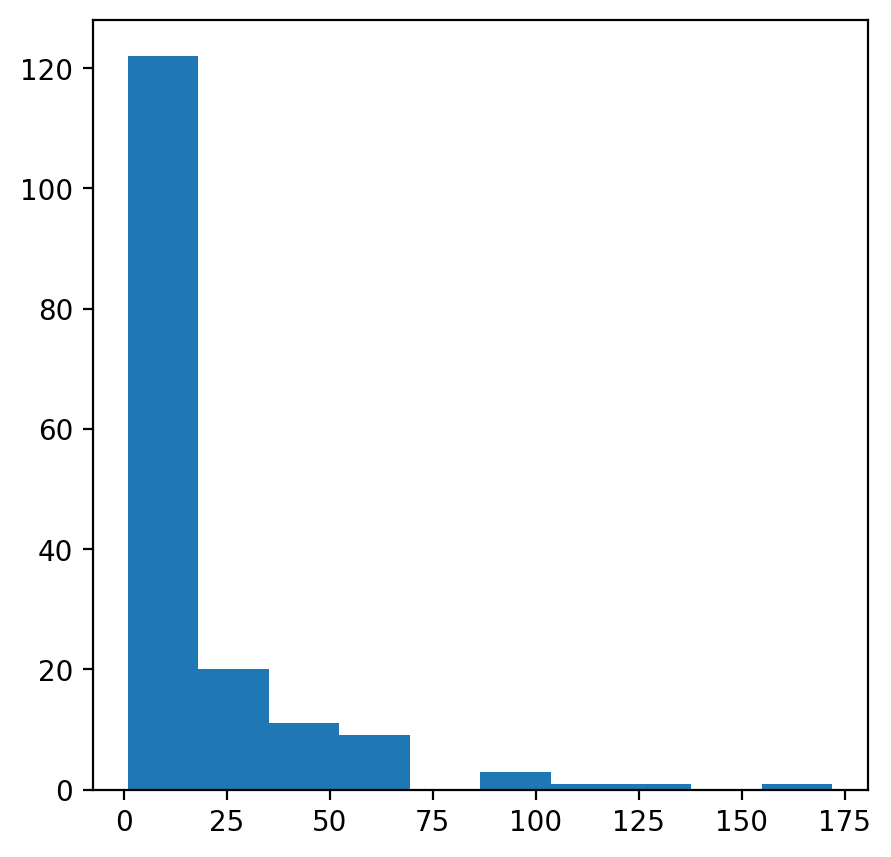

In [23]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [24]:
frequent_notes = [note_ for note_, count in freq.items() if count>=20]
print(len(frequent_notes))

45


In [25]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music,dtype=object)

In [26]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [27]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [28]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [29]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [30]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [31]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [32]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           4500      
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [33]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [34]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=100, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/100
12/13 [==========================>...] - ETA: 0s - loss: 3.7538
Epoch 1: val_loss improved from inf to 3.65195, saving model to best_model.h5
13/13 [==============================] - 3s 118ms/step - loss: 3.7482 - val_loss: 3.6520
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 3.6099
Epoch 2: val_loss improved from 3.65195 to 3.58974, saving model to best_model.h5
13/13 [==============================] - 1s 85ms/step - loss: 3.6080 - val_loss: 3.5897
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 3.5368
Epoch 3: val_loss improved from 3.58974 to 3.53650, saving model to best_model.h5
13/13 [==============================] - 1s 85ms/step - loss: 3.5408 - val_loss: 3.5365
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 3.4556
Epoch 4: val_loss improved from 3.53650 to 3.43553, saving model to best_model.h5
13/13 [==============================] - 1s 87ms/step - loss: 3.4555 - val_loss: 3.4355
Epoch 5/100
12/13 [

13/13 [==============================] - 2s 185ms/step - loss: 0.9656 - val_loss: 1.5290
Epoch 35/100
13/13 [==============================] - ETA: 0s - loss: 0.8887
Epoch 35: val_loss improved from 1.52897 to 1.47095, saving model to best_model.h5
13/13 [==============================] - 2s 182ms/step - loss: 0.8887 - val_loss: 1.4710
Epoch 36/100
13/13 [==============================] - ETA: 0s - loss: 0.8605
Epoch 36: val_loss did not improve from 1.47095
13/13 [==============================] - 2s 175ms/step - loss: 0.8605 - val_loss: 1.4865
Epoch 37/100
13/13 [==============================] - ETA: 0s - loss: 0.8381
Epoch 37: val_loss improved from 1.47095 to 1.44679, saving model to best_model.h5
13/13 [==============================] - 2s 153ms/step - loss: 0.8381 - val_loss: 1.4468
Epoch 38/100
13/13 [==============================] - ETA: 0s - loss: 0.8096
Epoch 38: val_loss did not improve from 1.44679
13/13 [==============================] - 2s 120ms/step - loss: 0.8096 - va

Epoch 72/100
13/13 [==============================] - ETA: 0s - loss: 0.3433
Epoch 72: val_loss did not improve from 1.39053
13/13 [==============================] - 1s 94ms/step - loss: 0.3433 - val_loss: 1.5478
Epoch 73/100
13/13 [==============================] - ETA: 0s - loss: 0.3531
Epoch 73: val_loss did not improve from 1.39053
13/13 [==============================] - 1s 98ms/step - loss: 0.3531 - val_loss: 1.5533
Epoch 74/100
13/13 [==============================] - ETA: 0s - loss: 0.3421
Epoch 74: val_loss did not improve from 1.39053
13/13 [==============================] - 1s 98ms/step - loss: 0.3421 - val_loss: 1.5683
Epoch 75/100
13/13 [==============================] - ETA: 0s - loss: 0.3050
Epoch 75: val_loss did not improve from 1.39053
13/13 [==============================] - 1s 105ms/step - loss: 0.3050 - val_loss: 1.6099
Epoch 76/100
13/13 [==============================] - ETA: 0s - loss: 0.3080
Epoch 76: val_loss did not improve from 1.39053
13/13 [===============

In [37]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

In [35]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(20):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

1/1 [==============================] - 0s 54ms/step
[15, 38, 23, 38, 15, 3, 15, 3, 15, 3, 3, 3, 3, 3, 15, 23, 23, 23, 23, 15]


In [38]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [39]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Tambourine()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Tambourine()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [41]:
convert_to_midi(predicted_notes)